In [1]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

In [2]:
# Low Light Enhancement
def enhance_low_light_image(image, brightness_factor=1.2):
    yuv_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    y, u, v = cv2.split(yuv_image)
    y = cv2.equalizeHist(y)
    y = np.clip(y * brightness_factor, 0, 255).astype(np.uint8)
    enhanced_yuv = cv2.merge([y, u, v])
    return cv2.cvtColor(enhanced_yuv, cv2.COLOR_YUV2BGR)

# Foggy Enhancement (DCP)
def dark_channel_prior(image, size=15):
    image = image.astype(np.float32)
    dark_channel = np.min(image, axis=2)
    dark_channel = cv2.erode(dark_channel, np.ones((size, size)))
    return dark_channel

def estimate_atmospheric_light(image, dark_channel):
    max_dark_value = np.max(dark_channel)
    atmospheric_light = image[np.where(dark_channel == max_dark_value)]
    return np.mean(atmospheric_light, axis=0)

def recover_image(image, dark_channel, atmospheric_light, omega=0.95, t0=0.1):
    transmission = 1 - omega * dark_channel / atmospheric_light[0]
    transmission = np.clip(transmission, t0, 1)
    recovered_image = (image - atmospheric_light[0]) / (transmission[..., None] + 0.1) + atmospheric_light[0]
    return np.clip(recovered_image, 0, 255).astype(np.uint8)

def apply_dcp(image):
    dark_channel = dark_channel_prior(image)
    atm_light = estimate_atmospheric_light(image, dark_channel)
    return recover_image(image, dark_channel, atm_light)

# Sunny Enhancement
def enhance_sunny_image(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    v = cv2.normalize(v, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    hsv_enhanced = cv2.merge([h, s, v])
    enhanced_image = cv2.cvtColor(hsv_enhanced, cv2.COLOR_HSV2BGR)
    lab = cv2.cvtColor(enhanced_image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    l_enhanced = clahe.apply(l)
    lab_enhanced = cv2.merge([l_enhanced, a, b])
    return cv2.cvtColor(lab_enhanced, cv2.COLOR_LAB2BGR)

# Rainy/Snowy Enhancement
def denoise_rainy_image(img):
    img = cv2.resize(img, (768, 1024))
    bilateral = cv2.bilateralFilter(img, d=9, sigmaColor=75, sigmaSpace=75)
    gray = cv2.cvtColor(bilateral, cv2.COLOR_BGR2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    morph = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel, iterations=1)
    morph_color = cv2.cvtColor(morph, cv2.COLOR_GRAY2BGR)
    rain_reduced = cv2.subtract(bilateral, morph_color)
    rain_cleaned = cv2.add(img, rain_reduced)
    denoised = cv2.fastNlMeansDenoisingColored(rain_cleaned, None, 5, 5, 7, 21)
    lab = cv2.cvtColor(denoised, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    contrast = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    sharpened = cv2.filter2D(contrast, -1, np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]]))
    return cv2.resize(sharpened, None, fx=1.5, fy=1.5, interpolation=cv2.INTER_CUBIC)

def denoise_snow_image(img):
    return denoise_rainy_image(img)


In [3]:
# Load your trained weather classification model
model = load_model(r"E:\downloads new\rename1.keras")
class_labels = ['foggy', 'lowlight', 'rainy', 'snowy', 'sunny']

img_path = r"D:\fypfinal\yolo_dataset\images\foggy\61.png"
original_img = cv2.imread(img_path)
resized_img = cv2.resize(original_img, (128, 128))
rgb_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
img_normalized = rgb_img / 255.0
input_tensor = np.expand_dims(img_normalized, axis=0)

# Predict class
predictions = model.predict(input_tensor)
predicted_class_index = np.argmax(predictions[0])
predicted_class_name = class_labels[predicted_class_index]
print("Predicted Weather Condition:", predicted_class_name)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Predicted Weather Condition: foggy


In [4]:
if predicted_class_name == "foggy":
    enhanced_img = apply_dcp(original_img)
elif predicted_class_name == "sunny":
    enhanced_img = enhance_sunny_image(original_img)
elif predicted_class_name == "lowlight":
    enhanced_img = enhance_low_light_image(original_img)
elif predicted_class_name == "rainy":
    enhanced_img = denoise_rainy_image(original_img)
elif predicted_class_name == "snowy":
    enhanced_img = denoise_snow_image(original_img)
else:
    enhanced_img = original_img.copy()


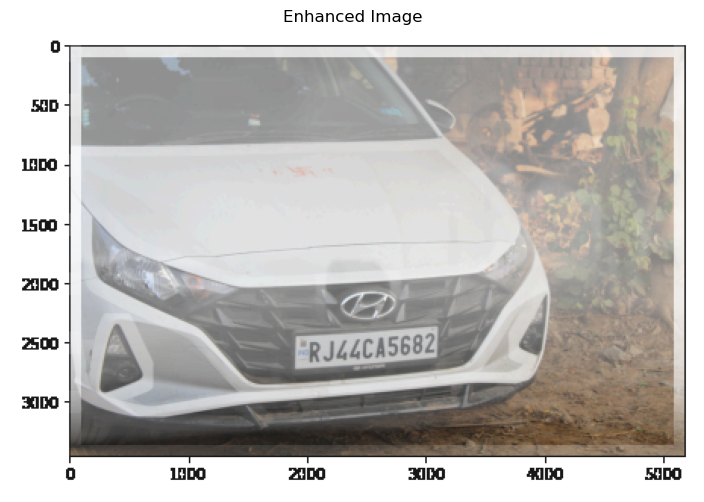

In [5]:
enhanced_img_rgb = cv2.cvtColor(enhanced_img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 6))
plt.imshow(enhanced_img_rgb)
plt.title("Enhanced Image")
plt.axis('off')
plt.show()


In [6]:
import os
count_file_path = r"C:\Users\HP\Desktop\cleaning result\image_count.txt"
output_dir = r"C:\Users\HP\Desktop\cleaning result"
os.makedirs(output_dir, exist_ok=True)

# Load or initialize count
if os.path.exists(count_file_path):
    with open(count_file_path, 'r') as f:
        image_count = int(f.read())
else:
    image_count = 0

# Save image
enhanced_img_path = os.path.join(output_dir, f"image{image_count}.jpg")
cv2.imwrite(enhanced_img_path, enhanced_img)
print(f"Enhanced image saved at: {enhanced_img_path}")

# Update count
image_count += 1
with open(count_file_path, 'w') as f:
    f.write(str(image_count))


Enhanced image saved at: C:\Users\HP\Desktop\cleaning result\image21.jpg


In [7]:
from ultralytics import YOLO
import subprocess

yolo_model_path = r"D:\fypfinal\last\bestyolo.pt"
yolo_output_dir = r"C:\Users\HP\Desktop\yolo_output"

yolo_command = (
    f'yolo task=detect mode=predict model="{yolo_model_path}" conf=0.25 '
    f'source="{enhanced_img_path}" save=True '
    f'project="{yolo_output_dir}" name="result1" exist_ok=True'
)

subprocess.run(yolo_command, shell=True)
print("YOLO detection completed.")


YOLO detection completed.


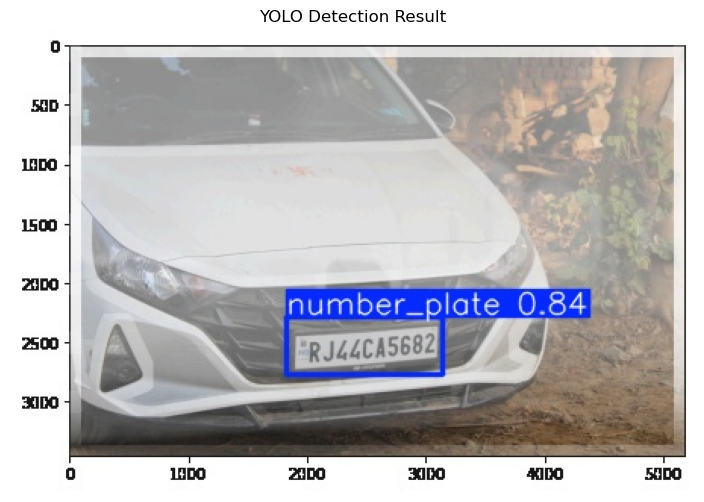

In [8]:
detected_output_img = os.path.join(yolo_output_dir, "result1", os.path.basename(enhanced_img_path))
if os.path.exists(detected_output_img):
    output_img = cv2.imread(detected_output_img)
    output_img_rgb = cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(10, 6))
    plt.imshow(output_img_rgb)
    plt.title("YOLO Detection Result")
    plt.axis('off')
    plt.show()
else:
    print("⚠️ YOLO result image not found.")


In [9]:
from paddleocr import PaddleOCR

# Initialize PaddleOCR and YOLO model
ocr = PaddleOCR(use_angle_cls=True, lang='en')
model = YOLO(yolo_model_path)

# Output folder for OCR results
output_base = r"C:\Users\HP\Desktop\new_ocr\paddleocr"
os.makedirs(output_base, exist_ok=True)

def get_next_output_folder(base_path):
    counter = 1
    while True:
        folder = os.path.join(base_path, f"run_{counter}")
        if not os.path.exists(folder):
            os.makedirs(folder)
            return folder
        counter += 1

output_folder = get_next_output_folder(output_base)

# Read image and run detection
image = cv2.imread(enhanced_img_path)
results = model(image)[0]

ocr_texts = []
for i, box in enumerate(results.boxes):
    x1, y1, x2, y2 = map(int, box.xyxy[0])
    cropped = image[y1:y2, x1:x2]

    result = ocr.ocr(cropped, cls=True)
    plate_text = result[0][0][1][0] if result and result[0] else ""
    ocr_texts.append(plate_text)

    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 255), 2)
    cv2.putText(image, plate_text, (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)
    cv2.imwrite(os.path.join(output_folder, f"plate_{i}.jpg"), cropped)

cv2.imwrite(os.path.join(output_folder, "annotated.jpg"), image)
with open(os.path.join(output_folder, "ocr.txt"), "w") as f:
    f.write("\n".join(ocr_texts))

print("OUTPUT SAVED IN:", output_folder)
print("PaddleOCR Output:", ocr_texts)


E:\jupyter\jupyternotebook\Lib\site-packages\paddle\utils\cpp_extension\extension_utils.py:711: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)


[2025/05/14 22:04:21] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\HP/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\HP/.paddleocr/whl\\rec\\en\\en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max

In [ ]:
# Low Light Enhancement
def enhance_low_light_image(image, brightness_factor=1.2):
    yuv_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    y, u, v = cv2.split(yuv_image)
    y = cv2.equalizeHist(y)
    y = np.clip(y * brightness_factor, 0, 255).astype(np.uint8)
    enhanced_yuv = cv2.merge([y, u, v])
    return cv2.cvtColor(enhanced_yuv, cv2.COLOR_YUV2BGR)

# Foggy Enhancement (DCP)
def dark_channel_prior(image, size=15):
    image = image.astype(np.float32)
    dark_channel = np.min(image, axis=2)
    dark_channel = cv2.erode(dark_channel, np.ones((size, size)))
    return dark_channel

def estimate_atmospheric_light(image, dark_channel):
    max_dark_value = np.max(dark_channel)
    atmospheric_light = image[np.where(dark_channel == max_dark_value)]
    return np.mean(atmospheric_light, axis=0)

def recover_image(image, dark_channel, atmospheric_light, omega=0.95, t0=0.1):
    transmission = 1 - omega * dark_channel / atmospheric_light[0]
    transmission = np.clip(transmission, t0, 1)
    recovered_image = (image - atmospheric_light[0]) / (transmission[..., None] + 0.1) + atmospheric_light[0]
    return np.clip(recovered_image, 0, 255).astype(np.uint8)

def apply_dcp(image):
    dark_channel = dark_channel_prior(image)
    atm_light = estimate_atmospheric_light(image, dark_channel)
    return recover_image(image, dark_channel, atm_light)

# Sunny Enhancement
def enhance_sunny_image(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    v = cv2.normalize(v, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    hsv_enhanced = cv2.merge([h, s, v])
    enhanced_image = cv2.cvtColor(hsv_enhanced, cv2.COLOR_HSV2BGR)
    lab = cv2.cvtColor(enhanced_image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    l_enhanced = clahe.apply(l)
    lab_enhanced = cv2.merge([l_enhanced, a, b])
    return cv2.cvtColor(lab_enhanced, cv2.COLOR_LAB2BGR)

# Rainy/Snowy Enhancement
def denoise_rainy_image(img):
    img = cv2.resize(img, (768, 1024))
    bilateral = cv2.bilateralFilter(img, d=9, sigmaColor=75, sigmaSpace=75)
    gray = cv2.cvtColor(bilateral, cv2.COLOR_BGR2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    morph = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel, iterations=1)
    morph_color = cv2.cvtColor(morph, cv2.COLOR_GRAY2BGR)
    rain_reduced = cv2.subtract(bilateral, morph_color)
    rain_cleaned = cv2.add(img, rain_reduced)
    denoised = cv2.fastNlMeansDenoisingColored(rain_cleaned, None, 5, 5, 7, 21)
    lab = cv2.cvtColor(denoised, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    contrast = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    sharpened = cv2.filter2D(contrast, -1, np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]]))
    return cv2.resize(sharpened, None, fx=1.5, fy=1.5, interpolation=cv2.INTER_CUBIC)

def denoise_snow_image(img):
    return denoise_rainy_image(img)

def run_ocr_pipeline(img_path):
    import os
    import cv2
    import numpy as np
    import matplotlib.pyplot as plt
    from tensorflow.keras.models import load_model
    from ultralytics import YOLO
    from paddleocr import PaddleOCR

    

    # ======== WEATHER ENHANCEMENT ========
    weather_model = load_model(r"E:\downloads new\rename1.keras")
    class_labels = ['foggy', 'lowlight', 'rainy', 'snowy', 'sunny']
    original_img = cv2.imread(img_path)
    resized_img = cv2.resize(original_img, (128, 128))
    rgb_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
    input_tensor = np.expand_dims(rgb_img / 255.0, axis=0)
    predictions = weather_model.predict(input_tensor)
    predicted_class = class_labels[np.argmax(predictions[0])]

    if predicted_class == "foggy":
        enhanced_img = apply_dcp(original_img)
    elif predicted_class == "sunny":
        enhanced_img = enhance_sunny_image(original_img)
    elif predicted_class == "lowlight":
        enhanced_img = enhance_low_light_image(original_img)
    elif predicted_class == "rainy":
        enhanced_img = denoise_rainy_image(original_img)
    elif predicted_class == "snowy":
        enhanced_img = denoise_snow_image(original_img)
    else:
        enhanced_img = original_img.copy()

    # ======== SAVE ENHANCED IMAGE ========
    count_file_path = r"C:\Users\HP\Desktop\cleaning result\image_count.txt"
    output_dir = r"C:\Users\HP\Desktop\cleaning result"
    os.makedirs(output_dir, exist_ok=True)
    if os.path.exists(count_file_path):
        with open(count_file_path, 'r') as f:
            image_count = int(f.read())
    else:
        image_count = 0

    enhanced_img_path = os.path.join(output_dir, f"image{image_count}.jpg")
    cv2.imwrite(enhanced_img_path, enhanced_img)
    with open(count_file_path, 'w') as f:
        f.write(str(image_count + 1))

    # ======== YOLO DETECTION ========
    yolo_model_path = r"D:\fypfinal\last\bestyolo.pt"
    yolo_output_dir = r"C:\Users\HP\Desktop\yolo_output"
    yolo_command = (
        f'yolo task=detect mode=predict model="{yolo_model_path}" conf=0.25 '
        f'source="{enhanced_img_path}" save=True '
        f'project="{yolo_output_dir}" name="result1" exist_ok=True'
    )
    subprocess.run(yolo_command, shell=True)
    result_img_path = os.path.join(yolo_output_dir, "result1", os.path.basename(enhanced_img_path))

    # ======== OCR DETECTION ========
    ocr = PaddleOCR(use_angle_cls=True, lang='en')
    model = YOLO(yolo_model_path)
    image = cv2.imread(enhanced_img_path)
    results = model(image)[0]

    ocr_texts = []
    output_base = r"C:\Users\HP\Desktop\new_ocr\paddleocr"
    os.makedirs(output_base, exist_ok=True)

    def get_next_output_folder(base_path):
        counter = 1
        while True:
            folder = os.path.join(base_path, f"run_{counter}")
            if not os.path.exists(folder):
                os.makedirs(folder)
                return folder
            counter += 1

    output_folder = get_next_output_folder(output_base)

    for i, box in enumerate(results.boxes):
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        cropped = image[y1:y2, x1:x2]
        result = ocr.ocr(cropped, cls=True)
        plate_text = result[0][0][1][0] if result and result[0] else ""
        ocr_texts.append(plate_text)

        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 255), 2)
        cv2.putText(image, plate_text, (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)
        cv2.imwrite(os.path.join(output_folder, f"plate_{i}.jpg"), cropped)

    cv2.imwrite(os.path.join(output_folder, "annotated.jpg"), image)
    with open(os.path.join(output_folder, "ocr.txt"), "w") as f:
        f.write("\n".join(ocr_texts))

    print("✅ OCR Texts:", ocr_texts)
    print("📂 Results saved to:", output_folder)
    return ocr_texts




ocr_texts = run_ocr_pipeline(r"D:\fypfinal\yolo_dataset\images\foggy\61.png")


E:\jupyter\jupyternotebook\Lib\site-packages\paddle\utils\cpp_extension\extension_utils.py:711: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)


In [1]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt



def process_video(img_path):
    # Load models
    weather_model = load_model(r"E:\downloads new\rename1.keras")
    class_labels = ['foggy', 'lowlight', 'rainy', 'snowy', 'sunny']
    yolo_model_path = r"D:\fypfinal\last\bestyolo.pt"
    output_dir = r"C:\Users\HP\Desktop\video_output"
    os.makedirs(output_dir, exist_ok=True)
    yolo_output_dir = os.path.join(output_dir, "yolo_results")
    os.makedirs(yolo_output_dir, exist_ok=True)

    # Open video
    cap = cv2.VideoCapture(img_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    ocr = PaddleOCR(use_angle_cls=True, lang='en')
    model = YOLO(yolo_model_path)

    # Create output folder for OCR results
    output_base = r"C:\Users\HP\Desktop\new_ocr\paddleocrvideo"
    os.makedirs(output_base, exist_ok=True)

    def get_next_output_folder(base_path):
        counter = 1
        while True:
            folder = os.path.join(base_path, f"run_{counter}")
            if not os.path.exists(folder):
                os.makedirs(folder)
                return folder
            counter += 1

    output_folder = get_next_output_folder(output_base)

    frame_num = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_num += 1
        print(f"Processing Frame {frame_num}/{frame_count}...")

        # ======== WEATHER ENHANCEMENT ========
        resized_img = cv2.resize(frame, (128, 128))
        rgb_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
        input_tensor = np.expand_dims(rgb_img / 255.0, axis=0)
        predictions = weather_model.predict(input_tensor)
        predicted_class = class_labels[np.argmax(predictions[0])]

        if predicted_class == "foggy":
            enhanced_img = apply_dcp(frame)
        elif predicted_class == "sunny":
            enhanced_img = enhance_sunny_image(frame)
        elif predicted_class == "lowlight":
            enhanced_img = enhance_low_light_image(frame)
        elif predicted_class == "rainy":
            enhanced_img = denoise_rainy_image(frame)
        elif predicted_class == "snowy":
            enhanced_img = denoise_snow_image(frame)
        else:
            enhanced_img = frame.copy()

        # ======== YOLO DETECTION ========
        yolo_command = (
            f'yolo task=detect mode=predict model="{yolo_model_path}" conf=0.25 '
            f'source="{enhanced_img}" save=True '
            f'project="{yolo_output_dir}" name="result_frame_{frame_num}" exist_ok=True'
        )
        subprocess.run(yolo_command, shell=True)
        result_img_path = os.path.join(yolo_output_dir, "result_frame_" + str(frame_num), f"image{frame_num}.jpg")

        # ======== OCR DETECTION ========
        results = model(enhanced_img)[0]
        ocr_texts = []

        for i, box in enumerate(results.boxes):
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            cropped = enhanced_img[y1:y2, x1:x2]
            result = ocr.ocr(cropped, cls=True)
            plate_text = result[0][0][1][0] if result and result[0] else ""
            ocr_texts.append(plate_text)

            # Annotate with bounding box and OCR text
            cv2.rectangle(enhanced_img, (x1, y1), (x2, y2), (0, 0, 255), 2)
            cv2.putText(enhanced_img, plate_text, (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)

        # Save OCR results for the frame
        cv2.imwrite(os.path.join(output_folder, f"frame_{frame_num}_annotated.jpg"), enhanced_img)
        with open(os.path.join(output_folder, f"frame_{frame_num}_ocr.txt"), "w") as f:
            f.write("\n".join(ocr_texts))

        print(f"✅ OCR Texts for Frame {frame_num}: {ocr_texts}")
        print(f"📂 Results saved to: {output_folder}")

    cap.release()

def apply_dcp(image):
    # Apply your DCP method (dummy implementation)
    return image

def enhance_sunny_image(image):
    # Enhance sunny image (dummy implementation)
    return image

def enhance_low_light_image(image):
    # Enhance low light image (dummy implementation)
    return image

def denoise_rainy_image(image):
    # Denoise rainy image (dummy implementation)
    return image

def denoise_snow_image(image):
    # Denoise snowy image (dummy implementation)
    return image

# Example usage
process_video(r"E:\downloads new\videoplayback (2).mp4")


NameError: name 'os' is not defined

In [13]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import os
import subprocess
from ultralytics import YOLO
from paddleocr import PaddleOCR

# Low Light Enhancement
def enhance_low_light_image(image, brightness_factor=1.2):
    yuv_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    y, u, v = cv2.split(yuv_image)
    y = cv2.equalizeHist(y)
    y = np.clip(y * brightness_factor, 0, 255).astype(np.uint8)
    enhanced_yuv = cv2.merge([y, u, v])
    return cv2.cvtColor(enhanced_yuv, cv2.COLOR_YUV2BGR)

# Foggy Enhancement (DCP)
def dark_channel_prior(image, size=15):
    image = image.astype(np.float32)
    dark_channel = np.min(image, axis=2)
    dark_channel = cv2.erode(dark_channel, np.ones((size, size)))
    return dark_channel

def estimate_atmospheric_light(image, dark_channel):
    max_dark_value = np.max(dark_channel)
    atmospheric_light = image[np.where(dark_channel == max_dark_value)]
    return np.mean(atmospheric_light, axis=0)

def recover_image(image, dark_channel, atmospheric_light, omega=0.95, t0=0.1):
    transmission = 1 - omega * dark_channel / atmospheric_light[0]
    transmission = np.clip(transmission, t0, 1)
    recovered_image = (image - atmospheric_light[0]) / (transmission[..., None] + 0.1) + atmospheric_light[0]
    return np.clip(recovered_image, 0, 255).astype(np.uint8)

def apply_dcp(image):
    dark_channel = dark_channel_prior(image)
    atm_light = estimate_atmospheric_light(image, dark_channel)
    return recover_image(image, dark_channel, atm_light)

# Sunny Enhancement
def enhance_sunny_image(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    v = cv2.normalize(v, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    hsv_enhanced = cv2.merge([h, s, v])
    enhanced_image = cv2.cvtColor(hsv_enhanced, cv2.COLOR_HSV2BGR)
    lab = cv2.cvtColor(enhanced_image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    l_enhanced = clahe.apply(l)
    lab_enhanced = cv2.merge([l_enhanced, a, b])
    return cv2.cvtColor(lab_enhanced, cv2.COLOR_LAB2BGR)

# Rainy/Snowy Enhancement
def denoise_rainy_image(img):
    img = cv2.resize(img, (768, 1024))
    bilateral = cv2.bilateralFilter(img, d=9, sigmaColor=75, sigmaSpace=75)
    gray = cv2.cvtColor(bilateral, cv2.COLOR_BGR2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    morph = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel, iterations=1)
    morph_color = cv2.cvtColor(morph, cv2.COLOR_GRAY2BGR)
    rain_reduced = cv2.subtract(bilateral, morph_color)
    rain_cleaned = cv2.add(img, rain_reduced)
    denoised = cv2.fastNlMeansDenoisingColored(rain_cleaned, None, 5, 5, 7, 21)
    lab = cv2.cvtColor(denoised, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    contrast = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    sharpened = cv2.filter2D(contrast, -1, np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]]))
    return cv2.resize(sharpened, None, fx=1.5, fy=1.5, interpolation=cv2.INTER_CUBIC)

def denoise_snow_image(img):
    return denoise_rainy_image(img)

# Function to process the image pipeline
def process_image(image_path, model_path, count_file_path, output_base):
    # Load image
    original_img = cv2.imread(image_path)

    # Preprocess image for prediction
    resized_img = cv2.resize(original_img, (128, 128))
    rgb_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
    img_normalized = rgb_img / 255.0
    input_tensor = np.expand_dims(img_normalized, axis=0)

    # Load your trained weather classification model
    model = load_model(model_path)
    class_labels = ['foggy', 'lowlight', 'rainy', 'snowy', 'sunny']

    # Predict class
    predictions = model.predict(input_tensor)
    predicted_class_index = np.argmax(predictions[0])
    predicted_class_name = class_labels[predicted_class_index]
    print("Predicted Weather Condition:", predicted_class_name)

    # Apply the corresponding enhancement
    if predicted_class_name == "foggy":
        enhanced_img = apply_dcp(original_img)
    elif predicted_class_name == "sunny":
        enhanced_img = enhance_sunny_image(original_img)
    elif predicted_class_name == "lowlight":
        enhanced_img = enhance_low_light_image(original_img)
    elif predicted_class_name == "rainy":
        enhanced_img = denoise_rainy_image(original_img)
    elif predicted_class_name == "snowy":
        enhanced_img = denoise_snow_image(original_img)
    else:
        enhanced_img = original_img.copy()

    # Save enhanced image
    os.makedirs(output_base, exist_ok=True)
    if os.path.exists(count_file_path):
        with open(count_file_path, 'r') as f:
            image_count = int(f.read())
    else:
        image_count = 0
    enhanced_img_path = os.path.join(output_base, f"image{image_count}.jpg")
    cv2.imwrite(enhanced_img_path, enhanced_img)
    print(f"Enhanced image saved at: {enhanced_img_path}")

    # Update count
    image_count += 1
    with open(count_file_path, 'w') as f:
        f.write(str(image_count))

    # Run YOLO detection on the enhanced image
    yolo_model_path = r"D:\fypfinal\last\bestyolo.pt"
    yolo_output_dir = os.path.join(output_base, "yolo_output")
    yolo_command = (
        f'yolo task=detect mode=predict model="{yolo_model_path}" conf=0.25 '
        f'source="{enhanced_img_path}" save=True '
        f'project="{yolo_output_dir}" name="result1" exist_ok=True'
    )
    subprocess.run(yolo_command, shell=True)
    print("YOLO detection completed.")

    # OCR using PaddleOCR
    ocr = PaddleOCR(use_angle_cls=True, lang='en')
    detected_output_img = os.path.join(yolo_output_dir, "result1", os.path.basename(enhanced_img_path))
    ocr_texts = []
    if os.path.exists(detected_output_img):
        image = cv2.imread(detected_output_img)
        results = YOLO(yolo_model_path)(image)[0]
        for i, box in enumerate(results.boxes):
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            cropped = image[y1:y2, x1:x2]
            result = ocr.ocr(cropped, cls=True)
            plate_text = result[0][0][1][0] if result and result[0] else ""
            ocr_texts.append(plate_text)
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 255), 2)
            cv2.putText(image, plate_text, (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)
        cv2.imwrite(os.path.join(output_base, "ocr_result.jpg"), image)
        with open(os.path.join(output_base, "ocr.txt"), "w") as f:
            f.write("\n".join(ocr_texts))
    else:
        print("⚠️ YOLO result image not found.")

    return ocr_texts


# Example usage:
image_path = r"D:\fypfinal\yolo_dataset\images\low_light\00375-90_87-512,365_633,407-633,399_525,399_526,361_634,361-0_0_10_9_30_30_25-104-5.jpg"
model_path = r"E:\downloads new\rename1.keras"
count_file_path = r"C:\Users\HP\Desktop\cleaning result\image_count.txt"
output_base = r"C:\Users\HP\Desktop\new_ocr\paddleocr"

ocr_results = process_image(image_path, model_path, count_file_path, output_base)
print("OCR Results:", ocr_results)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Weather Condition: lowlight
Enhanced image saved at: C:\Users\HP\Desktop\new_ocr\paddleocr\image19.jpg
YOLO detection completed.
[2025/05/14 21:56:44] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\HP/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_a